In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [11]:
!pip install torchSummary
!pip install albumentations

In [12]:
import os
import glob
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import albumentations as A

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
%cd /content/drive/MyDrive/Garbage classification

/content/drive/MyDrive/Garbage classification


In [15]:
path = "/content/drive/MyDrive/Garbage classification"
os.listdir(path)
glob.glob(path+"/*")

['/content/drive/MyDrive/Garbage classification/cardboard',
 '/content/drive/MyDrive/Garbage classification/trash',
 '/content/drive/MyDrive/Garbage classification/metal',
 '/content/drive/MyDrive/Garbage classification/glass',
 '/content/drive/MyDrive/Garbage classification/paper',
 '/content/drive/MyDrive/Garbage classification/plastic']

In [16]:
folders = glob.glob(path+"/*")
count = 0

for i in folders:
    count=0
    count+=len(os.listdir(i))
    print(i,' =  ', count)

/content/drive/MyDrive/Garbage classification/cardboard  =   403
/content/drive/MyDrive/Garbage classification/trash  =   137
/content/drive/MyDrive/Garbage classification/metal  =   410
/content/drive/MyDrive/Garbage classification/glass  =   501
/content/drive/MyDrive/Garbage classification/paper  =   594
/content/drive/MyDrive/Garbage classification/plastic  =   492


In [17]:
transform2  = A.Compose([
    A.HorizontalFlip(p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.2),
    A.VerticalFlip(p=0.2),
    A.Rotate(0,80),
    A.Resize(224,224),
    A.Normalize(max_pixel_value = 255.0,p=1)
])

In [18]:
import cv2
import imageio as iio
import PIL as image

class CustomDataset(Dataset):
    def __init__(self, transform = None):
        self.folder = path
        folders = glob.glob(self.folder + "/*")
#         print('folders',folders)

        self.transform = transform
        self.data = []
        for class_path in folders:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])

#         print(self.data[0])


        self.class_map = {
            'metal' : 0,
            'glass' : 1,
            'plastic' : 2,
            'paper':3,
            'cardboard':4,
            'trash' :5

        }
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224))

        # Augmentations
        if self.transform is not None:
            transformed = transform2(image = img)
            transformed_image = transformed['image']
            img = cv2.resize(img,(224,224))


        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        img_tensor = img_tensor.to(torch.float32)

        class_id = class_id
        return img_tensor, class_id

In [19]:
dataset = CustomDataset(transform = transform2)
len(dataset) # 2527 images

2537

In [20]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [2237, 300])

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size = 64, shuffle=False, num_workers=2)

In [22]:
for i, (j,k) in enumerate(val_dataloader):
    print(k)

tensor([2, 3, 2, 0, 1, 3, 2, 0, 2, 3, 3, 3, 4, 1, 3, 3, 0, 1, 4, 0, 5, 3, 0, 3,
        3, 4, 3, 3, 4, 4, 4, 4, 2, 4, 1, 3, 0, 0, 4, 4, 1, 1, 4, 2, 2, 3, 3, 1,
        0, 5, 4, 2, 5, 4, 2, 1, 1, 4, 0, 1, 3, 2, 2, 2])
tensor([3, 1, 3, 0, 3, 1, 4, 3, 1, 4, 1, 5, 2, 4, 2, 4, 3, 4, 3, 2, 3, 2, 0, 5,
        3, 3, 4, 3, 0, 0, 2, 4, 1, 1, 3, 2, 1, 5, 0, 4, 1, 5, 3, 0, 4, 4, 1, 4,
        5, 4, 2, 1, 3, 2, 2, 3, 0, 1, 3, 0, 3, 4, 3, 0])
tensor([2, 3, 1, 4, 4, 4, 0, 1, 1, 0, 0, 0, 3, 4, 3, 4, 1, 4, 5, 4, 1, 1, 1, 1,
        1, 2, 4, 3, 0, 1, 2, 1, 4, 0, 0, 2, 2, 0, 0, 3, 2, 0, 4, 4, 3, 4, 2, 2,
        4, 2, 2, 3, 2, 1, 1, 3, 3, 0, 2, 2, 3, 2, 1, 5])
tensor([3, 3, 1, 5, 1, 4, 4, 1, 0, 1, 3, 2, 0, 1, 0, 3, 2, 4, 2, 0, 3, 3, 5, 2,
        3, 3, 3, 3, 0, 0, 3, 3, 2, 3, 2, 5, 2, 3, 4, 1, 3, 0, 3, 3, 4, 1, 1, 2,
        1, 3, 3, 2, 1, 3, 1, 3, 4, 4, 3, 0, 2, 2, 1, 1])
tensor([3, 5, 5, 1, 2, 2, 1, 2, 0, 4, 3, 1, 3, 3, 5, 3, 2, 3, 1, 4, 4, 4, 3, 3,
        3, 3, 0, 1, 1, 0, 3, 4, 3, 3, 0, 3, 3, 3, 1,

In [23]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [24]:
class ResNet18(nn.Module):
  def __init__(self, in_channels, resblock, outputs=12):
    super().__init__()
    self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

    self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

    self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

    self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


    self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

#     self.gap = nn.AdaptiveAvgPool2d(1)
#     self.fc = nn.Linear(1024,12, device=device)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512 , 12)

  def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.avgpool(input)
#         print(input.shape)
        input = torch.flatten(input,1)
#         print(input.shape)

        input = self.fc(input)
#         print(input.shape)

        return input

In [25]:
from torchsummary import summary

resnet18 = ResNet18(3, ResBlock, outputs=6)
resnet18.to(device)
summary(resnet18, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
       BatchNorm2d-3           [-1, 64, 56, 56]             128
              ReLU-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,928
       BatchNorm2d-8           [-1, 64, 56, 56]             128
          ResBlock-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,928
      BatchNorm2d-11           [-1, 64, 56, 56]             128
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
         ResBlock-14           [-1, 64,

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)

In [29]:
import time
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()



            output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = targets.data.cpu().numpy()
            y_true.extend(labels) # Save Truth


    print('Accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))
    return y_pred, y_true

In [31]:
t0 = time.time()
resnet_num_epochs = 50
resnet_val_losses = []
resnet_train_losses = []

for epoch in range(resnet_num_epochs):
    train_loss= 0.0
    for i, (inputs,targets) in enumerate(train_dataloader):

        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = resnet18(inputs)

        optimizer.zero_grad()

        train_loss = criterion(outputs, targets)
            #         print(train_loss.item())

            # backward pass

        train_loss.backward()

            # update parameters
        optimizer.step()
    resnet_train_losses.append(train_loss.item())

    resnet18.eval()
    val_loss = 0.0
    for i, (inputs, targets) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)

            # forward pass
        outputs = resnet18(inputs)

        val_loss = criterion(outputs, targets)

    resnet_val_losses.append(val_loss.item())


    scheduler.step(val_loss)

    print('training Loss at epoch ', epoch+1 , "=" ,train_loss.item())
    print('validation Loss at epoch ', epoch+1 , "=" ,val_loss.item())
    evaluate_model(resnet18, val_dataloader, device)
t1 = time.time()
print("Total time taken " ,(t1-t0)/60 )

training Loss at epoch  1 = 1.243315577507019
validation Loss at epoch  1 = 1.2833759784698486
Accuracy: 45.33
training Loss at epoch  2 = 1.4705711603164673
validation Loss at epoch  2 = 1.634048581123352
Accuracy: 38.00
training Loss at epoch  3 = 1.6521888971328735
validation Loss at epoch  3 = 1.763257622718811
Accuracy: 26.00
training Loss at epoch  4 = 1.6130448579788208
validation Loss at epoch  4 = 1.5319182872772217
Accuracy: 36.33
training Loss at epoch  5 = 1.4219379425048828
validation Loss at epoch  5 = 1.3967020511627197
Accuracy: 37.00
training Loss at epoch  6 = 1.3900799751281738
validation Loss at epoch  6 = 1.2943358421325684
Accuracy: 47.67
training Loss at epoch  7 = 1.1646960973739624
validation Loss at epoch  7 = 1.0645638704299927
Accuracy: 56.33
training Loss at epoch  8 = 1.3093409538269043
validation Loss at epoch  8 = 1.0216790437698364
Accuracy: 53.67
training Loss at epoch  9 = 1.2560547590255737
validation Loss at epoch  9 = 0.8648425936698914
Accuracy: 5

In [32]:
def plot_train_curve(train_losses):
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses)
    plt.xlabel('Iteration')
    plt.ylabel('Training loss')
    plt.title('NLL Loss')
    plt.show()

In [33]:
def plot_val_curve(val_losses):
    plt.figure(figsize = (10,4))
    plt.plot(val_losses)
    plt.xlabel('Iteration')
    plt.ylabel('Validation loss')
    plt.title('NLL Loss')
    plt.show()

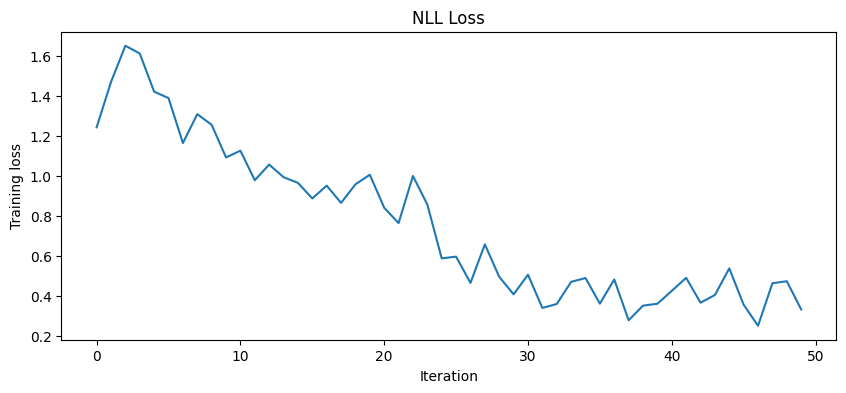

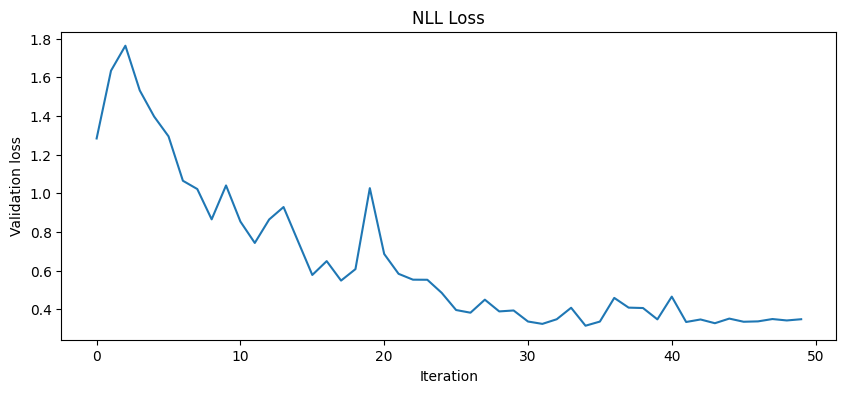

In [34]:
plot_train_curve(resnet_train_losses)
plot_val_curve(resnet_val_losses)

In [35]:
classes = {
            'metal' : 0,
            'glass' : 1,
            'plastic' : 2,
            'paper':3,
            'cardboard':4,
            'trash' :5
          }

In [36]:
y_pred, y_true = evaluate_model(resnet18, val_dataloader, device)

Accuracy: 82.00


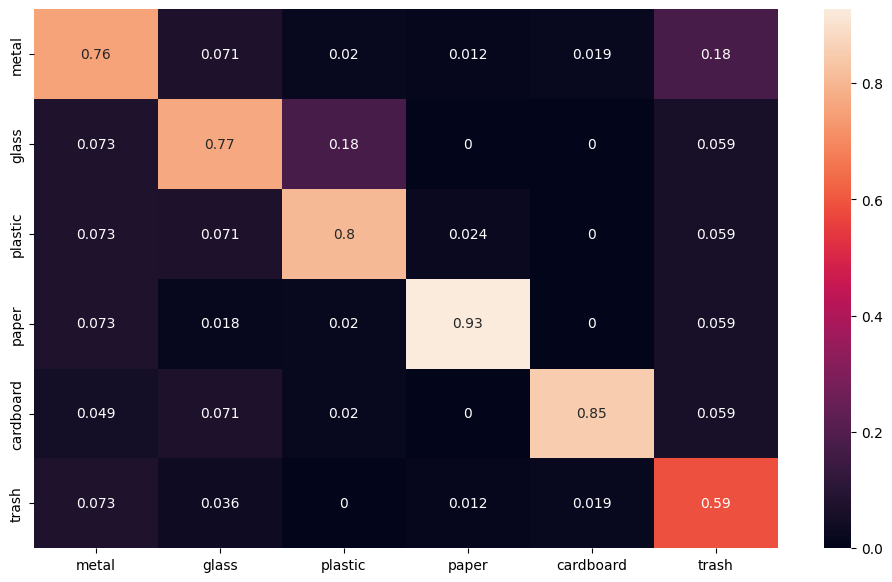

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output2.png')